<a href="https://colab.research.google.com/github/anggastudio/AlternateResponseValue/blob/master/PlayReview_Scrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a Dataset for Sentiment Analysis

## Setup

Let's install the required packages and setup the imports:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -qq google-play-scraper

In [ ]:
!pip install -qq -U watermark

     |████████████████████████████████| 1.6 MB 4.7 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.9.0

pandas             : 1.3.5
matplotlib         : 3.2.2
seaborn            : 0.11.2
google_play_scraper: 1.2.2



In [ ]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

## The Goal of the Dataset

You want to get feedback for your app. Both negative and positive are good. But the negative one can reveal critical features that are missing or downtime of your service (when it is much more frequent).

Lucky for us, Google Play has plenty of apps, reviews, and scores. We can scrape app info and reviews using the [google-play-scraper](https://github.com/JoMingyu/google-play-scraper) package.

You can choose plenty of apps to analyze. But different app categories contain different audiences, domain-specific quirks, and more. We'll start simple.

We want apps that have been around some time, so opinion is collected organically. We want to mitigate advertising strategies as much as possible. Apps are constantly being updated, so the time of the review is an important factor.

Ideally, you would want to collect every possible review and work with that. However, in the real world data is often limited (too large, inaccessible, etc). So, we'll do the best we can.

Let's choose some apps that fit the criteria from the *Productivity* category. We'll use [AppAnnie](https://www.appannie.com/apps/google-play/top-chart/?country=US&category=29&device=&date=2020-04-05&feed=All&rank_sorting_type=rank&page_number=1&page_size=100&table_selections=) to select some of the top US apps:

In [ ]:
app_packages = [
  'com.Info_BMKG'
]

## Scraping App Information

Let's scrape the info for each app:

In [ ]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='in', country='id')
  del info['comments']
  app_infos.append(info)

100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


We got the info for all 15 apps. Let's write a helper function that prints JSON objects a bit better:

In [ ]:
def print_json(json_object):
  json_str = json.dumps(
    json_object, 
    indent=2, 
    sort_keys=True, 
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Here is a sample app information from the list:

In [ ]:
print_json(app_infos[0])

{
  "adSupported": false,
  "appId": "com.Info_BMKG",
  "containsAds": false,
  "contentRating": "Rating 3+",
  "contentRatingDescription": null,
  "currency": "IDR",
  "description": "Informasi Cuaca, Iklim, Kualitas Udara, dan Gempabumi yang terjadi di Indonesia. Aplikasi mobile ini resmi dirilis oleh Badan Meteorologi, Klimatologi dan Geofisika (BMKG).\r\n\r\nFitur-fitur dalam aplikasi mobile Info BMKG:\r\n\r\n1. Prakiraan Cuaca\r\nMenyajikan informasi prakiraan cuaca dalam 7 harian di seluruh kecamatan di Indonesia\r\n\r\n2. Gempabumi\r\nMenyajikan informasi gempabumi terkini M \u2265 5.0, gempabumi dirasakan, dan gempabumi real-time disertai jarak lokasi gempa dengan lokasi Anda\r\n\r\n3. Iklim\r\nMenyajikan beberapa informasi iklim di wilayah Indonesia, diantaranya:\r\n- Hari Tanpa Hujan\r\n- Prakiraan Hujan Bulanan\r\n- Analisis Hujan Bulanan\r\n\r\n4. Kualitas Udara\r\nMenyajikan informasi kualitas udara dalam konsentrasi Partikulat Matter (PM2.5) di beberapa kota di Indonesia\

This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5). Let's ignore all of that and have a look at their beautiful icons:

## Scraping App Reviews

In an ideal world, we would get all the reviews. But there are lots of them and we're scraping the data. That wouldn't be very polite. What should we do?

We want:

- Balanced dataset - roughly the same number of reviews for each score (1-5)
- A representative sample of the reviews for each app

We can satisfy the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness, which are the reviews that Google Play thinks are most important. Just in case, we'll get a subset from the newest, too:

In [ ]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='id',
        country='id',
        sort=sort_order,
        #count = 0 if (1 < score < 5) else 5000,
        count = 20000 if score == 5 else 20000,
        filter_score_with=score
      )
      for r in rvs:
      #  r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'most_relevant'
         r['appId'] = ap
      app_reviews.extend(rvs)

100%|██████████| 1/1 [00:19<00:00, 19.29s/it]


Note that we're adding the app id and sort order to each review. Here's an example for one:

In [ ]:
print_json(app_reviews[0])

{
  "appId": "com.Info_BMKG",
  "at": "2022-09-05 07:55:16",
  "content": "Tidak akurat, saya daerah Jayapura, Keerom Arso, kemarin hujan, ini hari hujan, tapi di BMKG kemarin dan ini hari di tulis tidak hujan, gimana sih, masa sampai dua hari meleset berturut turut",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": "2.9.1",
  "reviewId": "a7b2402f-0b8c-45e7-b60f-bb32a5f1d7fd",
  "score": 1,
  "thumbsUpCount": 0,
  "userImage": "https://play-lh.googleusercontent.com/a-/AFdZuco9K5wt5EsiiFjmyQgIRhnvbd4GhBl45CcZplBi",
  "userName": "RIZAL Gaming"
}



`repliedAt` and `replyContent` contain the developer response to the review. Of course, they can be missing.

How many app reviews did we get?



In [ ]:
len(app_reviews)

18152

Let's save the reviews to a CSV file:

In [ ]:
app_reviews_df = pd.DataFrame(app_reviews)
#app_reviews_df.to_csv('/content/drive/MyDrive/Colab Notebooks/reviews.csv', index=None, header=True)
app_reviews_df.to_csv('/content/drive/MyDrive/reviews-info-bmkg-en.csv', index=None, header=True)

## Summary

Well done! You now have a dataset with more than 15k user reviews from 15 productivity apps. Of course, you can go crazy and get much much more.

- [Read the tutorial](https://www.curiousily.com/posts/create-dataset-for-sentiment-analysis-by-scraping-google-play-app-reviews-using-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1GDJIpz7BXw55jl9wTOMQDool9m8DIOyp)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Set goals and expectations for your dataset
- Scrape Google Play app information
- Scrape user reviews for Google Play apps
- Save the dataset to CSV files

Next, we're going to use the reviews for sentiment analysis with BERT. But first, we'll have to do some text preprocessing!


## References

- [Google Play Scraper for Python](https://github.com/JoMingyu/google-play-scraper)

# Data Exploration

In [ ]:
#df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/reviews.csv")
df = pd.read_csv("/content/drive/MyDrive/reviews-info-bmkg.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appId
0,a0d4a535-bfcf-43fa-b322-dc175f319e8f,hanhan channel,https://play-lh.googleusercontent.com/a-/AFdZu...,Kaya nya sih bagus cuman sayang di fiture cuac...,1,0,2.9.1,2022-09-07 06:08:08,NaN,NaN,com.Info_BMKG
1,a7b2402f-0b8c-45e7-b60f-bb32a5f1d7fd,RIZAL Gaming,https://play-lh.googleusercontent.com/a-/AFdZu...,"Tidak akurat, saya daerah Jayapura, Keerom Ars...",1,0,2.9.1,2022-09-05 07:55:16,NaN,NaN,com.Info_BMKG
2,1fa22ddb-9b17-4d60-9559-1e11f0a56ab3,Kapu,https://play-lh.googleusercontent.com/a/AItbvm...,info cuacanya sangat tak sesuai,1,0,NaN,2022-08-26 10:54:01,NaN,NaN,com.Info_BMKG
3,1ffb9d7a-db35-45d5-91cb-d3ff85623223,J2 PRIME,https://play-lh.googleusercontent.com/a/AItbvm...,Ga guna masa udh gempa gk ada notif,1,1,NaN,2022-08-23 14:44:07,NaN,NaN,com.Info_BMKG
4,3745858f-e03a-4d4e-b081-13edf09d3227,arief001 Arief001,https://play-lh.googleusercontent.com/a/AItbvm...,"Di Vivo T1 5G, notifikasi tidak bisa muncul me...",1,0,NaN,2022-08-10 14:14:25,NaN,NaN,com.Info_BMKG


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18154 entries, 0 to 18153
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              18154 non-null  object
 1   userName              18154 non-null  object
 2   userImage             18154 non-null  object
 3   content               18144 non-null  object
 4   score                 18154 non-null  int64 
 5   thumbsUpCount         18154 non-null  int64 
 6   reviewCreatedVersion  12514 non-null  object
 7   at                    18154 non-null  object
 8   replyContent          189 non-null    object
 9   repliedAt             189 non-null    object
 10  appId                 18154 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.5+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


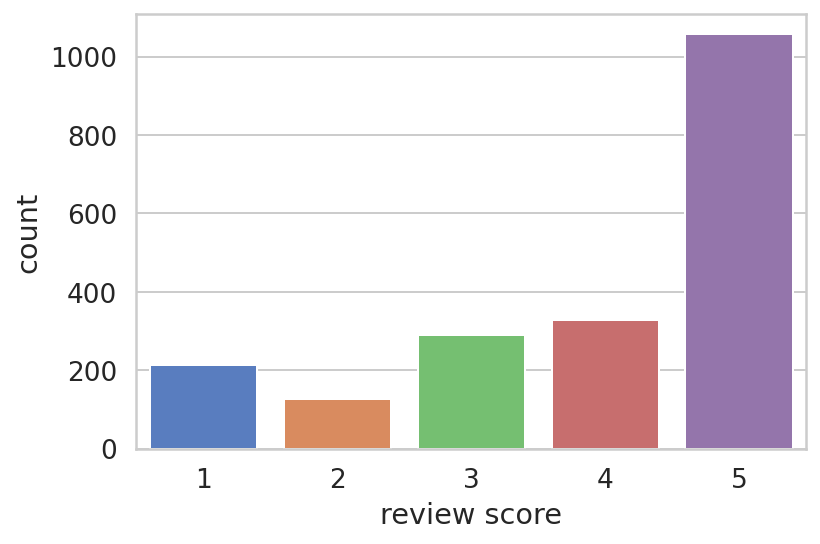

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating < 3:
    return 0
  elif rating > 3:
    return 2
  else: 
    return 1

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'netral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


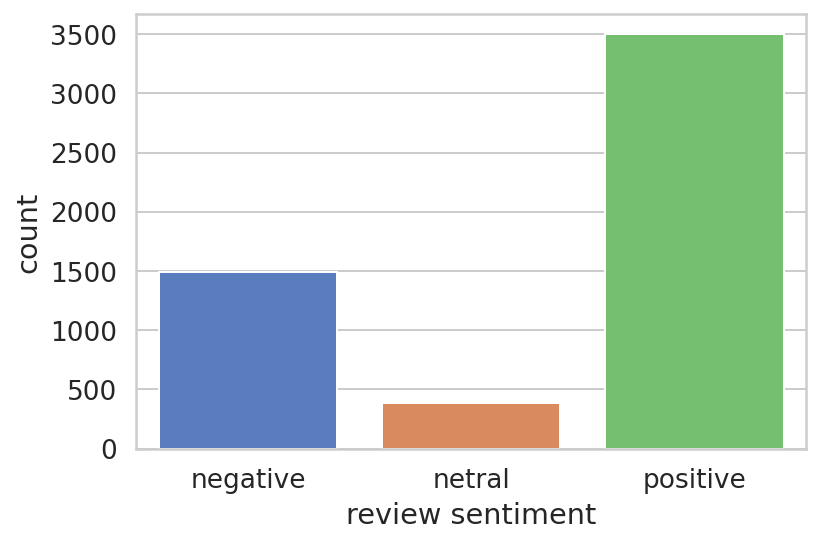

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);